<a href="https://colab.research.google.com/github/mxykb/413CW1/blob/main/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/300
100/100 [==============================] - 1s 1ms/step - loss: 0.2039
Epoch 2/300
100/100 [==============================] - 0s 1ms/step - loss: 0.0745
Epoch 3/300
100/100 [==============================] - 0s 1ms/step - loss: 0.0582
Epoch 4/300
100/100 [==============================] - 0s 1ms/step - loss: 0.0479
Epoch 5/300
100/100 [==============================] - 0s 1ms/step - loss: 0.0459
Epoch 6/300
100/100 [==============================] - 0s 1ms/step - loss: 0.0382
Epoch 7/300
100/100 [==============================] - 0s 1ms/step - loss: 0.0342
Epoch 8/300
100/100 [==============================] - 0s 1ms/step - loss: 0.0337
Epoch 9/300
100/100 [==============================] - 0s 1ms/step - loss: 0.0334
Epoch 10/300
100/100 [==============================] - 0s 1ms/step - loss: 0.0297
Epoch 11/300
100/100 [==============================] - 0s 1ms/step - loss: 0.0298
Epoch 12/300
100/100 [==============================] - 0s 1ms/step - loss: 0.0262
Epoch 13/300


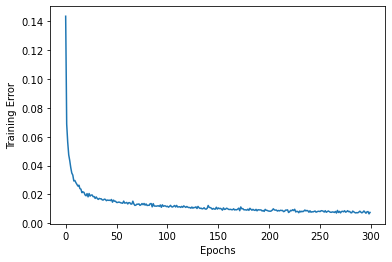

accuracy: 0.989 
 precision: 0.9890363137015563 
 recall: 0.989 
 F1 : 0.9889930158730159


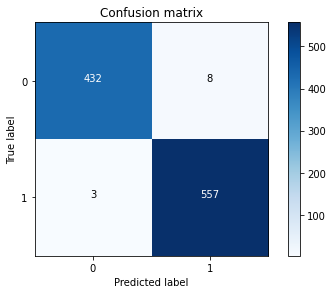

In [1]:
#-*-coding:utf-8-*-

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import pywt
import math
import numpy as np
import pandas as pd
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras import optimizers
from keras.layers import Dense, Dropout
import itertools
from keras.layers import Activation

def score(y_test,predictions):
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average="weighted")
    precision = metrics.precision_score(y_test, predictions, average="weighted")
    F1 = metrics.f1_score(y_test, predictions, average="weighted")  
    print("accuracy:",  accuracy, '\n', "precision:", precision, '\n', "recall:", recall, '\n', "F1 :",  F1)
    return accuracy,precision,recall,F1

def plot_confusion_matrix(cm, classes, title="Confusion Matrix", cmap=plt.cm.Blues):
    """
    The function prints and plots the confusion matrix
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)#set colour map from deep to light
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes)) #The lables of the cluster
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
ecg = raw_data[:, 0:-1]

def denoise(ecg):
    index=[]
    data=[]
    coffs=[]
    
    for i in range(len(ecg)-1):
        X=float(i)
        Y=float(ecg[i])
        index.append(X)
        data.append(Y)
    #create wavelet object and define parameters
    w=pywt.Wavelet('db8')#choose Daubechies8 wavelet
    maxlev=pywt.dwt_max_level(len(data),w.dec_len)
    
    threshold=0  #Threshold for filtering
    
    #Decompose into wavelet components,to the level selected:
    coffs=pywt.wavedec(data,'db8',level=maxlev) #Wavelet decomposition of signals
    
    for i in range(1,len(coffs)):
        coffs[i]=pywt.threshold(coffs[i],threshold*max(coffs[i]))
    
    datarec=pywt.waverec(coffs,'db8')#Wavelet reconstruction of signals
    return np.array(datarec)

denoiseData=np.array([])
min_val = tf.reduce_min(ecg)
max_val = tf.reduce_max(ecg)
ecg = (ecg - min_val) / (max_val - min_val)
for ecgdata in ecg:
    if(len(denoiseData) == 0):
        denoiseData = denoise(ecgdata)
    else:
        denoiseData = np.vstack((denoiseData,denoise(ecgdata)))

train_data, test_data, train_labels, test_labels = train_test_split(denoiseData, labels, test_size=0.2, random_state=21)


X = train_data
y = train_labels

digits = 2
examples = y.shape[0]
y = y.reshape(1, examples)
Y = np.eye(digits)[y.astype('int32')]
Y = Y.T.reshape(digits, examples).T


X2 = test_data
y2 = test_labels

examples = y2.shape[0]
y2 = y2.reshape(1, examples)
Y2 = np.eye(digits)[y2.astype('int32')]
Y2 = Y2.T.reshape(digits, examples).T

model = Sequential()

model = Sequential([
    Dense(64, input_shape=(140,), use_bias=True,activation='relu'),#一个Dense层
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, use_bias=True, activation='softmax')#一个Dense层
])

batch_size = 40
learning_rate = 0.003
epochs = 300
#Create a SGD object to adjust learning rate
sgd = optimizers.SGD(lr=learning_rate)
#Compile the model, the optimizer uses the newly created SDD object, and the loss function uses the minimum mean square deviation MSE
model.compile(optimizer=sgd, loss='mse')

hist = model.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=1)
plt.plot(hist.history["loss"]);
plt.xlabel('Epochs');
plt.ylabel('Training Error');
plt.show()

predict = model.predict(X2)
predict = np.argmax(predict, axis=1)
Y2= np.argmax(Y2, axis=1)
cnf_matrix = confusion_matrix(Y2, predict)#create confusion matrix
accuracy1,precision1,recall1,f1 = score(Y2,predict)#calculate the score of the model
class_names=[0,1]
plt.figure#plot the confusion matrix
plot_confusion_matrix(cnf_matrix,classes=class_names, title="Confusion matrix")
plt.show()